In [61]:
# (C) 2019 The Johns Hopkins University Applied Physics Laboratory LLC.

import requests

ENTRY_POINT='localhost:5000'
EVE_HEADERS = {'Content-Type': 'application/json'}

def get_items(resource):
    url = 'http://%s/%s' % (ENTRY_POINT, resource)
    response = requests.get(url, headers=EVE_HEADERS)
    if response.status_code == 200:
        r = response.json()
        if '_items' in r:
            if '_links' in r and 'next' in r['_links']:
                return r['_items'], r['_links']['next']['href']
            else:
                return r['_items'], None
    return [], None


def get_all_items(query):
    total_items = []
    while True:
        items, query = get_items(query)
        total_items.extend(items)
        if query is None:
            break
    return total_items


collection_id='5d14d3b1923299001714a22c'

def get_doc_annotations(collection_id, exclude=None):
    #get documents
    resource = 'documents?where={"collection_id":"%s"}' % (collection_id)
    docs = get_all_items(resource)

    #get annotations 
    resource = 'annotations?where={"collection_id":"%s"}' % (collection_id)
    annotations = get_all_items(resource)

    combined = {}
    for d in docs:
        combined[d['_id']]={"_id":d['_id'], "metadata":d['metadata'], "text":d['text'], "annotations":{}}

    for a in annotations:
        creator = a['creator_id']
        if exclude and creator in exclude :
            continue
        docid = a['document_id']
        anns = a['annotation']
        if docid in combined:
            combined[docid]["annotations"][creator]=anns
    return combined

In [62]:
combined = get_doc_annotations(collection_id, exclude=set(['bchee1']))

In [63]:
labels = set()
for v in combined.values():
    for ann_list in v['annotations'].values():
        for ann in ann_list:
            if len(ann)==3:
                labels.add(ann[2])
print(labels)

{'dose', 'stop_other', 'ind_skin', 'stop_AE', 'ind_other', 'stop_cost', 'stop_tapered', 'past_med', 'ind_muscle', 'frequency', 'stop_ineff', 'ind_joint', 'end_date', 'ind_lung', 'start_date', 'curr_med'}


In [64]:
import json

with open('myositis_labeled_bak.json', 'wt') as file:
    for k, c in combined.items():
        file.write(json.dumps(c) + "\n")


# Inter-Annotator Agreement Report

* Token-based F1 agreement

## Project Setup

* 2 annotators: cmecoli1, jalbayd1
* 180 agreement documents
* 16 labels

## Agreement per Document

| Document                 |   Mean F1 |   SD F1 |
|--------------------------|-----------|---------|
| 5d14d3b1923299001714a22f |     0.683 |   0.000 |
| 5d14d3b1923299001714a230 |     0.712 |   0.000 |
| 5d14d3b1923299001714a231 |     0.585 |   0.000 |
| 5d14d3b1923299001714a232 |     0.575 |   0.000 |
| 5d14d3b1923299001714a233 |   nan     | nan     |
| 5d14d3b1923299001714a234 |     0.892 |   0.000 |
| 5d14d3b1923299001714a235 |     0.901 |   0.000 |
| 5d14d3b1923299001714a236 |     0.694 |   0.000 |
| 5d14d3b1923299001714a237 |     0.614 |   0.000 |
| 5d14d3b1923299001714a238 |   nan     | nan     |
| 5d14d3b1923299001714a239 |     1.000 |   0.000 |
| 5d14d3b1923299001714a23a |     0.667 |   0.000 |
| 5d14d3b1923299001714a23b |     0.973 |   0.000 |
| 5d14d3b1923299001714a23c |     0.929 |   0.000 |
|

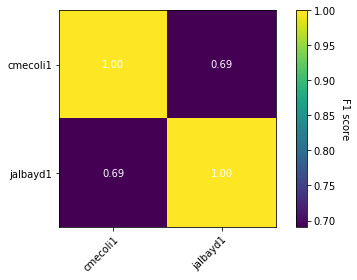

In [2]:
import json

anns=[]
with open('myositis_labeled_bak.json', 'rt') as file:
    for line in file:
        anns.append(json.loads(line))
from bratiaa.agree import iaa_report, compute_f1_agreement, input_generator
from bratiaa.utils import tokenize
from bratiaa.evaluation import exact_match_token_evaluation

token_func = tokenize
eval_func = exact_match_token_evaluation
labels = ['dose', 'stop_other', 'ind_skin', 'stop_AE', 'ind_other', 'stop_cost', 'stop_tapered', 
          'past_med', 'ind_muscle', 'frequency', 'stop_ineff', 'ind_joint', 'end_date', 'ind_lung', 
          'start_date', 'curr_med']

annotators, documents = input_generator(anns)

f1_agreement = compute_f1_agreement(annotators, documents, labels, eval_func=eval_func, token_func=token_func)
iaa_report(f1_agreement, 3)
f1_agreement.draw_heatmap('heatmap.png')


In [7]:
from collections import defaultdict
#Get label counts by provider
counts = defaultdict(lambda: defaultdict(int))
for document in anns:
    for per, ann_list in document['annotations'].items():
        for a in ann_list:
            if len(a)==3:
                counts[per][a[2]]+=1
print(counts)

for label in labels:
    print(label)
    for person, label_counts in counts.items():
        if label in label_counts:
            print('\t', person, label_counts[label])

defaultdict(<function <lambda> at 0x7f6f17419620>, {'cmecoli1': defaultdict(<class 'int'>, {'curr_med': 790, 'stop_tapered': 11, 'past_med': 305, 'ind_skin': 100, 'stop_cost': 3, 'start_date': 87, 'dose': 332, 'frequency': 257, 'end_date': 18, 'ind_muscle': 191, 'ind_joint': 73, 'stop_ineff': 36, 'stop_other': 2, 'ind_lung': 30, 'stop_AE': 7, 'ind_other': 1}), 'jalbayd1': defaultdict(<class 'int'>, {'end_date': 20, 'curr_med': 1018, 'past_med': 334, 'ind_skin': 314, 'dose': 449, 'frequency': 320, 'stop_cost': 5, 'start_date': 106, 'ind_muscle': 346, 'ind_other': 32, 'ind_joint': 121, 'stop_ineff': 21, 'ind_lung': 41, 'stop_AE': 20, 'stop_other': 7, 'stop_tapered': 6})})
dose
	 cmecoli1 332
	 jalbayd1 449
stop_other
	 cmecoli1 2
	 jalbayd1 7
ind_skin
	 cmecoli1 100
	 jalbayd1 314
stop_AE
	 cmecoli1 7
	 jalbayd1 20
ind_other
	 cmecoli1 1
	 jalbayd1 32
stop_cost
	 cmecoli1 3
	 jalbayd1 5
stop_tapered
	 cmecoli1 11
	 jalbayd1 6
past_med
	 cmecoli1 305
	 jalbayd1 334
ind_muscle
	 cmecoli1 1